<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_4_imdb_reviews_with_GRU_LSTM_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Building Models for the IMDB Reviews Dataset

In this lab, you will build four models and train it on the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) with full word encoding. These use different layers after the embedding namely `Flatten`, `LSTM`, `GRU`, and `Conv1D`. You will compare the performance and see which architecture might be best for this particular dataset. Let's begin!

In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 27 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,622 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 15s (28.8 MB/s)
(Reading database ... 123942 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
(Reading database ... 123919 files and directories currently installed.)
Prepar

In [14]:
%pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.3 MB/s 


## Imports

You will first import common libraries that will be used throughout the exercise.

In [15]:
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download and Prepare the Dataset

Next, you will download the `plain_text` version of the `IMDB Reviews` dataset.

In [3]:
# Download the plain text dataset
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3A9Z9G/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3A9Z9G/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3A9Z9G/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Get the train and test sets
train_data, test_data = imdb["train"], imdb["test"]

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s, l in train_data:
    training_sentences.append(s.numpy().decode("utf8"))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s, l in test_data:
    testing_sentences.append(s.numpy().decode("utf8"))
    testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [5]:
training_sentences[0]

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [6]:
training_labels_final[0]

0

Unlike the subword encoded set you've been using in the previous labs, you will need to build the vocabulary from scratch and generate padded sequences. You already know how to do that with the `Tokenizer` class and `pad_sequences()` method.

In [7]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type = "post"
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(
    testing_sequences, 
    maxlen=max_length, 
    truncating=trunc_type
)

In [8]:
testing_sentences[0]

"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."

In [9]:
[tokenizer.index_word[i] for i in [48, 24, 106, 13, 95]]

['there', 'are', 'films', 'that', 'make']

In [10]:
testing_padded[0]

array([  48,   24,  106,   13,   95, 4066,   16,  740, 5065,   10,   14,
        312,    5,    2,  579,  349,   16, 1847, 1257,    1,   16,  668,
       7666, 5531,    1,  761,    6,   13, 1026,    1,    1,  425,  478,
          1,    4,    1,  327, 3560,   20,  229,    3,   15, 5742,    3,
         15, 1620,   15,   99,    5,    2, 3550,  100,   11,  772, 1498,
         12,  252,  235,   11,  217,    2,  366, 6454,    3,   58,   93,
         11,   90,  102,   11, 1498,  177,   12,  252,   36,    6, 1126,
          1,  674,    7, 4387,    1,    4,    1,  327,    7,   36, 8300,
        366,    5, 1403,    1,   13,   29,   60,   26,    6,  867,  178,
         17,    4, 1037,    5,   12,  227,    3,   79,    4,  345,   32,
        345, 5159,    5,   10,    6, 1314, 1143,    2, 5619,    1],
      dtype=int32)

## Plot Utility

Before you define the models, you will define the function below so you can easily visualize the accuracy and loss history after training.

In [12]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()

## Model 1: Embedding w/ Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

*Note: You might see a different graph in the lectures. This is because we adjusted the `BATCH_SIZE` for training so subsequent models will train faster.*

In [ ]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_flatten.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Print the model summary
model_flatten.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_8 (Dense)             (None, 6)                 11526     
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(
    padded,
    training_labels_final,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(testing_padded, testing_labels_final),
)

Epoch 1/10
196/196 [==============================] - 2s 8ms/step - loss: 0.6031 - accuracy: 0.6671 - val_loss: 0.4233 - val_accuracy: 0.8114
Epoch 2/10
196/196 [==============================] - 1s 6ms/step - loss: 0.3139 - accuracy: 0.8724 - val_loss: 0.3728 - val_accuracy: 0.8344
Epoch 3/10
196/196 [==============================] - 1s 6ms/step - loss: 0.1977 - accuracy: 0.9318 - val_loss: 0.4008 - val_accuracy: 0.8248
Epoch 4/10
196/196 [==============================] - 1s 6ms/step - loss: 0.1091 - accuracy: 0.9723 - val_loss: 0.4447 - val_accuracy: 0.8209
Epoch 5/10
196/196 [==============================] - 1s 7ms/step - loss: 0.0499 - accuracy: 0.9939 - val_loss: 0.4985 - val_accuracy: 0.8172
Epoch 6/10
196/196 [==============================] - 1s 6ms/step - loss: 0.0244 - accuracy: 0.9982 - val_loss: 0.5466 - val_accuracy: 0.8144
Epoch 7/10
196/196 [==============================] - 1s 7ms/step - loss: 0.0134 - accuracy: 0.9990 - val_loss: 0.5863 - val_accuracy: 0.8128
Epoch 

In [ ]:
_loss, _acc = model_flatten.evaluate(testing_padded, testing_labels_final)

print(f'LOSS: {_loss}\nACCURACY: {_acc}')

782/782 [==============================] - 3s 3ms/step - loss: 0.6837 - accuracy: 0.8104
LOSS: 0.6837048530578613
ACCURACY: 0.8104000091552734


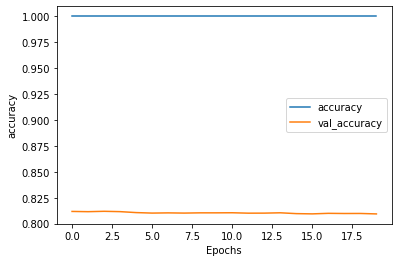

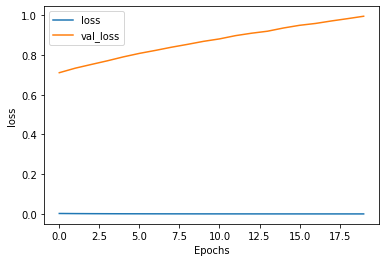

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, "accuracy")
plot_graphs(history_flatten, "loss")

## Model 1a: Embedding w/ Global Average Pooling

In [ ]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_average = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_average.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Print the model summary
model_average.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 6)                 102       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 6  # anymore that 6 and the model starts overfitting
BATCH_SIZE = 128

# Train the model
history_average = model_average.fit(
    padded,
    training_labels_final,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(testing_padded, testing_labels_final),
)

Epoch 1/6
196/196 [==============================] - 2s 8ms/step - loss: 0.6758 - accuracy: 0.6810 - val_loss: 0.6420 - val_accuracy: 0.7397
Epoch 2/6
196/196 [==============================] - 1s 7ms/step - loss: 0.5693 - accuracy: 0.7861 - val_loss: 0.5154 - val_accuracy: 0.7944
Epoch 3/6
196/196 [==============================] - 1s 7ms/step - loss: 0.4384 - accuracy: 0.8354 - val_loss: 0.4293 - val_accuracy: 0.8172
Epoch 4/6
196/196 [==============================] - 1s 6ms/step - loss: 0.3620 - accuracy: 0.8589 - val_loss: 0.3946 - val_accuracy: 0.8240
Epoch 5/6
196/196 [==============================] - 1s 6ms/step - loss: 0.3180 - accuracy: 0.8726 - val_loss: 0.3759 - val_accuracy: 0.8330
Epoch 6/6
196/196 [==============================] - 1s 7ms/step - loss: 0.2879 - accuracy: 0.8834 - val_loss: 0.3691 - val_accuracy: 0.8357


In [ ]:
_loss, _acc = model_average.evaluate(testing_padded, testing_labels_final)

print(f'LOSS: {_loss}\nACCURACY: {_acc}')

782/782 [==============================] - 2s 3ms/step - loss: 0.3691 - accuracy: 0.8357
LOSS: 0.36908766627311707
ACCURACY: 0.8357200026512146


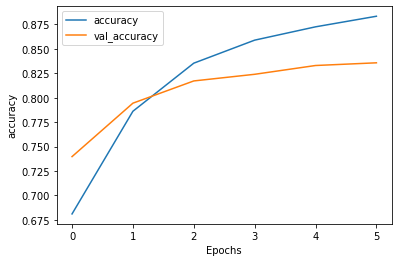

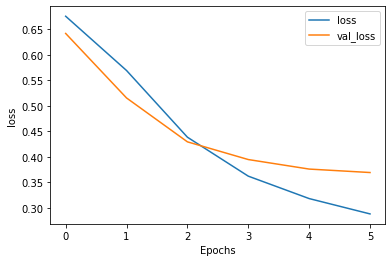

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_average, "accuracy")
plot_graphs(history_average, "loss")

## Model 2: Embeddings w/ BRNN (LSTM units)

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [ ]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_10 (Dense)            (None, 6)                 390       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(
    padded,
    training_labels_final,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(testing_padded, testing_labels_final),
)

Epoch 1/10
196/196 [==============================] - 7s 20ms/step - loss: 0.5624 - accuracy: 0.6892 - val_loss: 0.4136 - val_accuracy: 0.8130
Epoch 2/10
196/196 [==============================] - 3s 16ms/step - loss: 0.3129 - accuracy: 0.8732 - val_loss: 0.4096 - val_accuracy: 0.8163
Epoch 3/10
196/196 [==============================] - 3s 16ms/step - loss: 0.2462 - accuracy: 0.9046 - val_loss: 0.4307 - val_accuracy: 0.8221
Epoch 4/10
196/196 [==============================] - 3s 16ms/step - loss: 0.2065 - accuracy: 0.9219 - val_loss: 0.4521 - val_accuracy: 0.8166
Epoch 5/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1747 - accuracy: 0.9389 - val_loss: 0.4613 - val_accuracy: 0.8087
Epoch 6/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1438 - accuracy: 0.9524 - val_loss: 0.6257 - val_accuracy: 0.8047
Epoch 7/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1168 - accuracy: 0.9635 - val_loss: 0.6785 - val_accuracy: 0.7949

In [ ]:
_loss, _acc = model_lstm.evaluate(testing_padded, testing_labels_final)

print(f'LOSS: {_loss}\nACCURACY: {_acc}')

782/782 [==============================] - 5s 7ms/step - loss: 0.8356 - accuracy: 0.7953
LOSS: 0.8356006741523743
ACCURACY: 0.7953199744224548


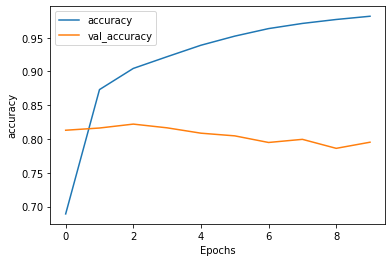

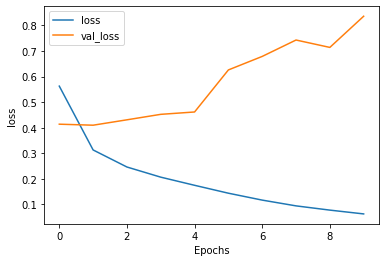

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, "accuracy")
plot_graphs(history_lstm, "loss")

## Model 2a: Embeddings w/ BRNN (LSTM units & Dropout)

"... all recurrent layers (except for `keras.layers.RNN`) and all cells provided by Keras have a `dropout` hyperparameter and a `recurrent_dropout` hyperparameter: the former defines the dropout rate to apply to the inputs (at each timestep), and the latter defines the dropout rate for the hidden states (also at each time step)."



In [25]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm_dropout = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, dropout=0.5, recurrent_dropout=0.5)),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_lstm_dropout.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model_lstm_dropout.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 6)                 390       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [26]:
NUM_EPOCHS = 10
BATCH_SIZE = 512

# Train the model
history_lstm_dropout = model_lstm_dropout.fit(
    padded,
    training_labels_final,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(testing_padded, testing_labels_final),
)

Epoch 1/10
49/49 [==============================] - 55s 1s/step - loss: 0.6816 - accuracy: 0.5546 - val_loss: 0.5997 - val_accuracy: 0.6898
Epoch 2/10
49/49 [==============================] - 52s 1s/step - loss: 0.4804 - accuracy: 0.7832 - val_loss: 0.4093 - val_accuracy: 0.8176
Epoch 3/10
49/49 [==============================] - 51s 1s/step - loss: 0.3504 - accuracy: 0.8550 - val_loss: 0.4031 - val_accuracy: 0.8252
Epoch 4/10
49/49 [==============================] - 52s 1s/step - loss: 0.3019 - accuracy: 0.8782 - val_loss: 0.4015 - val_accuracy: 0.8294
Epoch 5/10
49/49 [==============================] - 50s 1s/step - loss: 0.2675 - accuracy: 0.8946 - val_loss: 0.4333 - val_accuracy: 0.8245
Epoch 6/10
49/49 [==============================] - 50s 1s/step - loss: 0.2423 - accuracy: 0.9070 - val_loss: 0.4389 - val_accuracy: 0.8265
Epoch 7/10
49/49 [==============================] - 50s 1s/step - loss: 0.2297 - accuracy: 0.9132 - val_loss: 0.4976 - val_accuracy: 0.8192
Epoch 8/10
49/49 [==

In [27]:
_loss, _acc = model_lstm_dropout.evaluate(testing_padded, testing_labels_final)

print(f'LOSS: {_loss}\nACCURACY: {_acc}')

AttributeError: ignored

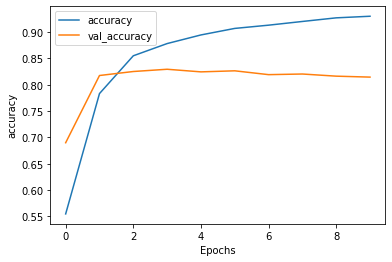

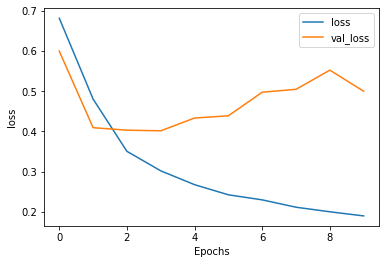

In [29]:
# Plot the accuracy and loss history
plot_graphs(history_lstm_dropout, "accuracy")
plot_graphs(history_lstm_dropout, "loss")

## Model 2b: Embeddings w/ Multilayer BRNN (LSTM units & Dropout)


In [30]:
# Parameters
embedding_dim = 16
lstm_dim1 = 32
lstm_dim2 = 16
dense_dim = 6

# Model Definition with LSTM
model_multi_lstm_dropout = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm_dim1, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm_dim2, dropout=0.5, recurrent_dropout=0.5)
        ),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_multi_lstm_dropout.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model_multi_lstm_dropout.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 120, 64)          12544     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 6)                 198       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 183,117
Trainable params: 183,117
Non-tr

In [31]:
NUM_EPOCHS = 10
BATCH_SIZE = 512

# Train the model
history_multi_lstm_dropout = model_multi_lstm_dropout.fit(
    padded,
    training_labels_final,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(testing_padded, testing_labels_final),
)

Epoch 1/10
49/49 [==============================] - 111s 2s/step - loss: 0.6900 - accuracy: 0.5342 - val_loss: 0.6649 - val_accuracy: 0.6363
Epoch 2/10
49/49 [==============================] - 96s 2s/step - loss: 0.5288 - accuracy: 0.7445 - val_loss: 0.4502 - val_accuracy: 0.7958
Epoch 3/10
49/49 [==============================] - 98s 2s/step - loss: 0.3685 - accuracy: 0.8474 - val_loss: 0.3994 - val_accuracy: 0.8280
Epoch 4/10
49/49 [==============================] - 97s 2s/step - loss: 0.3004 - accuracy: 0.8806 - val_loss: 0.4141 - val_accuracy: 0.8213
Epoch 5/10
49/49 [==============================] - 100s 2s/step - loss: 0.2665 - accuracy: 0.8977 - val_loss: 0.4154 - val_accuracy: 0.8269
Epoch 6/10
49/49 [==============================] - 99s 2s/step - loss: 0.2414 - accuracy: 0.9085 - val_loss: 0.4342 - val_accuracy: 0.8207
Epoch 7/10
49/49 [==============================] - 96s 2s/step - loss: 0.2213 - accuracy: 0.9169 - val_loss: 0.4605 - val_accuracy: 0.8152
Epoch 8/10
49/49 [

In [33]:
_loss, _acc = model_multi_lstm_dropout.evaluate(testing_padded, testing_labels_final, batch_size=1000)

print(f'LOSS: {_loss}\nACCURACY: {_acc}')

25/25 [==============================] - 3s 133ms/step - loss: 0.5114 - accuracy: 0.8130
LOSS: 0.5113986134529114
ACCURACY: 0.8129600286483765


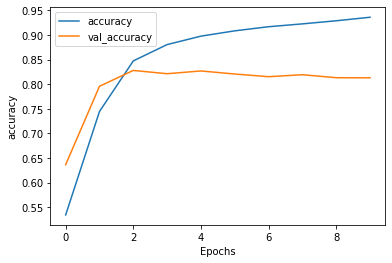

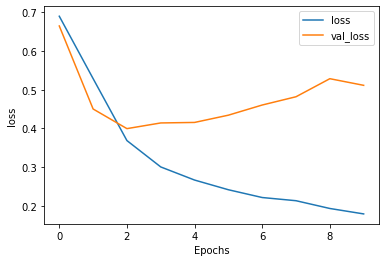

In [34]:
# Plot the accuracy and loss history
plot_graphs(history_multi_lstm_dropout, "accuracy")
plot_graphs(history_multi_lstm_dropout, "loss")

## Model 3: Embeddings w/ BRNN (GRU units)

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [ ]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_gru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 6)                 390       
                                                                 
 dense_13 (Dense)            (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(
    padded,
    training_labels_final,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(testing_padded, testing_labels_final),
)

Epoch 1/10
196/196 [==============================] - 7s 20ms/step - loss: 0.5997 - accuracy: 0.6394 - val_loss: 0.4084 - val_accuracy: 0.8168
Epoch 2/10
196/196 [==============================] - 3s 16ms/step - loss: 0.3234 - accuracy: 0.8674 - val_loss: 0.3928 - val_accuracy: 0.8306
Epoch 3/10
196/196 [==============================] - 3s 16ms/step - loss: 0.2420 - accuracy: 0.9068 - val_loss: 0.4030 - val_accuracy: 0.8234
Epoch 4/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1892 - accuracy: 0.9317 - val_loss: 0.4681 - val_accuracy: 0.8150
Epoch 5/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1453 - accuracy: 0.9500 - val_loss: 0.5528 - val_accuracy: 0.8114
Epoch 6/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1114 - accuracy: 0.9616 - val_loss: 0.6974 - val_accuracy: 0.8092
Epoch 7/10
196/196 [==============================] - 3s 16ms/step - loss: 0.0893 - accuracy: 0.9694 - val_loss: 0.7616 - val_accuracy: 0.7907

In [ ]:
_loss, _acc = model_gru.evaluate(testing_padded, testing_labels_final)

print(f'LOSS: {_loss}\nACCURACY: {_acc}')

782/782 [==============================] - 5s 6ms/step - loss: 1.0033 - accuracy: 0.7910
LOSS: 1.0033338069915771
ACCURACY: 0.7909600138664246


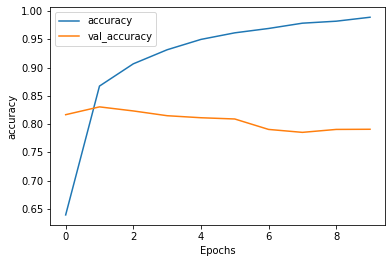

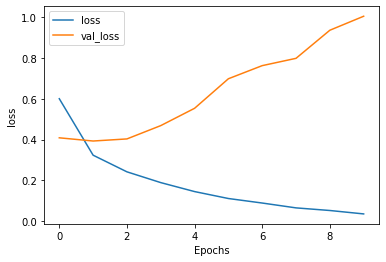

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_gru, "accuracy")
plot_graphs(history_gru, "loss")

## Embeddings w/ Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [ ]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Conv1D(filters, kernel_size, activation="relu"),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_conv.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model_conv.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 6)                 774       
                                                                 
 dense_15 (Dense)            (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(
    padded,
    training_labels_final,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(testing_padded, testing_labels_final),
)

Epoch 1/10
196/196 [==============================] - 4s 8ms/step - loss: 0.5378 - accuracy: 0.7388 - val_loss: 0.3907 - val_accuracy: 0.8262
Epoch 2/10
196/196 [==============================] - 2s 8ms/step - loss: 0.3041 - accuracy: 0.8746 - val_loss: 0.3826 - val_accuracy: 0.8290
Epoch 3/10
196/196 [==============================] - 2s 8ms/step - loss: 0.2434 - accuracy: 0.9038 - val_loss: 0.4045 - val_accuracy: 0.8278
Epoch 4/10
196/196 [==============================] - 2s 8ms/step - loss: 0.2087 - accuracy: 0.9201 - val_loss: 0.4443 - val_accuracy: 0.8215
Epoch 5/10
196/196 [==============================] - 1s 7ms/step - loss: 0.1831 - accuracy: 0.9327 - val_loss: 0.4892 - val_accuracy: 0.8138
Epoch 6/10
196/196 [==============================] - 2s 8ms/step - loss: 0.1606 - accuracy: 0.9428 - val_loss: 0.5215 - val_accuracy: 0.8118
Epoch 7/10
196/196 [==============================] - 1s 7ms/step - loss: 0.1441 - accuracy: 0.9504 - val_loss: 0.5755 - val_accuracy: 0.8054
Epoch 

In [ ]:
_loss, _acc = model_conv.evaluate(testing_padded, testing_labels_final)

print(f'LOSS: {_loss}\nACCURACY: {_acc}')

782/782 [==============================] - 2s 3ms/step - loss: 0.7204 - accuracy: 0.7989
LOSS: 0.7204328775405884
ACCURACY: 0.7989199757575989


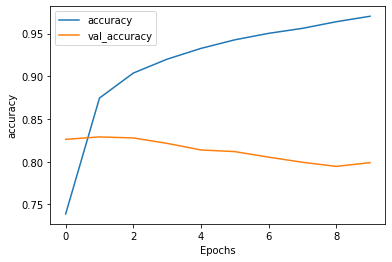

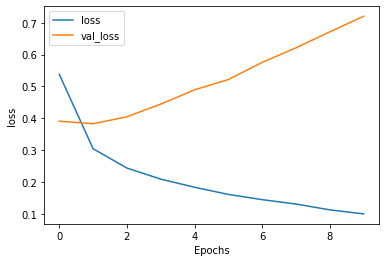

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_conv, "accuracy")
plot_graphs(history_conv, "loss")

## Wrap Up

Now that you've seen the results for each model, can you make a recommendation on what works best for this dataset? Do you still get the same results if you tweak some hyperparameters like the vocabulary size? Try tweaking some of the values some more so you can get more insight on what model performs best.